# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

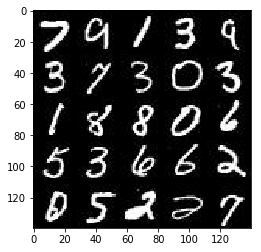

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

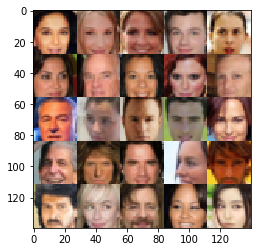

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    return inputs_real, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
alpha = 0.1

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
                                
        flat   = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
alpha = 0.1

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
       
        # Reshape it to start the convolutional stack
        # 7x7x224
        x1 = tf.reshape(x1, (-1, 7, 7, 256))        
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # Double to 14x14x112
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # Double to 28x28x56
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """ 

    # Setup the network
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every=10
    show_every=100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch in get_batches(batch_size):
                steps += 1
                
                # scale the batch
                batch_i = batch * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_i, 
                    input_z: batch_z, 
                    lr: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z,
                    lr: learning_rate 
                })

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_i})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3234... Generator Loss: 4.6400
Epoch 1/2... Discriminator Loss: 0.4257... Generator Loss: 2.7402


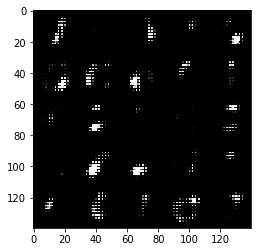

Epoch 1/2... Discriminator Loss: 0.4034... Generator Loss: 3.1197
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.5839


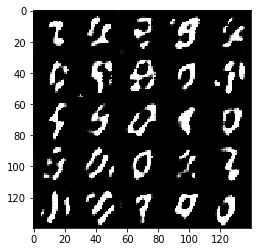

Epoch 1/2... Discriminator Loss: 1.8139... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 1.5535


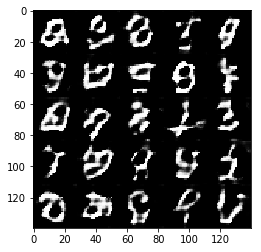

Epoch 1/2... Discriminator Loss: 1.0809... Generator Loss: 0.7919
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 0.8601


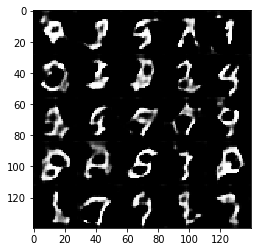

Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 2.0967
Epoch 1/2... Discriminator Loss: 0.7563... Generator Loss: 1.2159


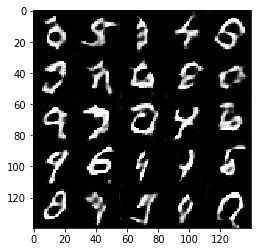

Epoch 1/2... Discriminator Loss: 0.7019... Generator Loss: 1.6131
Epoch 1/2... Discriminator Loss: 1.0966... Generator Loss: 2.9439


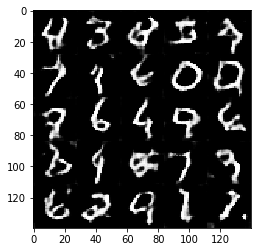

Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.4882
Epoch 1/2... Discriminator Loss: 0.6933... Generator Loss: 1.6847


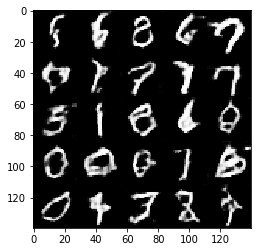

Epoch 1/2... Discriminator Loss: 0.6599... Generator Loss: 1.4305
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 0.9713


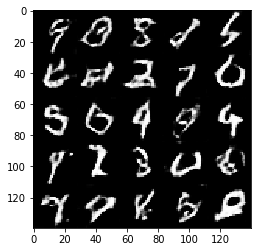

Epoch 1/2... Discriminator Loss: 0.9169... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 1.4271


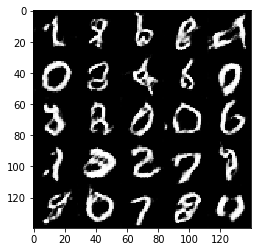

Epoch 2/2... Discriminator Loss: 0.6285... Generator Loss: 1.6542
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 0.8281


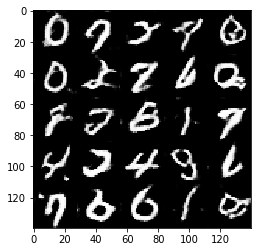

Epoch 2/2... Discriminator Loss: 0.8352... Generator Loss: 0.8473
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.0284


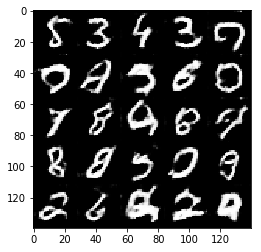

Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 1.0117


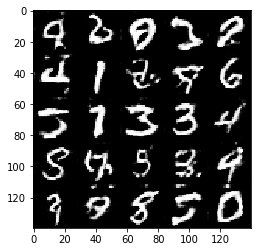

Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 0.9398


KeyboardInterrupt: 

In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.7

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5342... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 3.9608
Epoch 1/1... Discriminator Loss: 0.0476... Generator Loss: 4.3209
Epoch 1/1... Discriminator Loss: 0.1055... Generator Loss: 3.1951
Epoch 1/1... Discriminator Loss: 0.1040... Generator Loss: 3.9046
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 10.0811
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 2.6067
Epoch 1/1... Discriminator Loss: 0.1625... Generator Loss: 3.7266
Epoch 1/1... Discriminator Loss: 0.2763... Generator Loss: 2.1491
Epoch 1/1... Discriminator Loss: 0.1424... Generator Loss: 4.6093


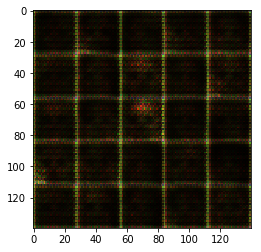

Epoch 1/1... Discriminator Loss: 0.1219... Generator Loss: 3.3255
Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 2.7586
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 5.7365
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 1.9504
Epoch 1/1... Discriminator Loss: 0.1404... Generator Loss: 4.9393
Epoch 1/1... Discriminator Loss: 0.1553... Generator Loss: 3.2132
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 9.7598
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 2.7688
Epoch 1/1... Discriminator Loss: 0.1790... Generator Loss: 2.9214
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.4679


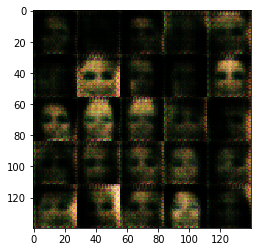

Epoch 1/1... Discriminator Loss: 0.3082... Generator Loss: 2.1852
Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 2.9169
Epoch 1/1... Discriminator Loss: 0.1506... Generator Loss: 4.2649
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 2.8830
Epoch 1/1... Discriminator Loss: 0.2355... Generator Loss: 2.4857
Epoch 1/1... Discriminator Loss: 0.2128... Generator Loss: 4.2334
Epoch 1/1... Discriminator Loss: 0.3189... Generator Loss: 2.1870
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.5183
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 2.4534


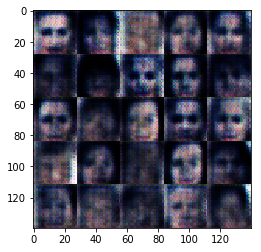

Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 2.4070
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 0.3188... Generator Loss: 2.8309
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 2.7217
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 1.9231
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 2.7825
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 2.5432
Epoch 1/1... Discriminator Loss: 0.2233... Generator Loss: 2.5816


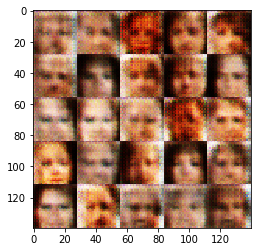

Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 2.3121
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 2.6147
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 2.2126
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 2.1321
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.1575
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 2.3912
Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 2.2617
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.3986


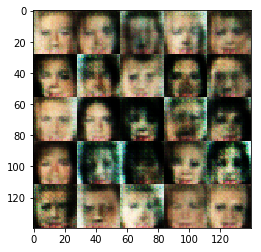

Epoch 1/1... Discriminator Loss: 0.3257... Generator Loss: 2.3187
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 1.9389
Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 1.9299
Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 1.8253
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.4148
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 2.0448


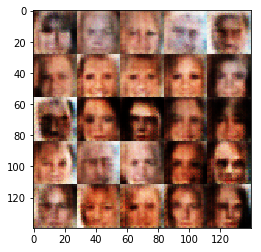

Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 2.1245
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.4749
Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 1.5597
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 1.3687


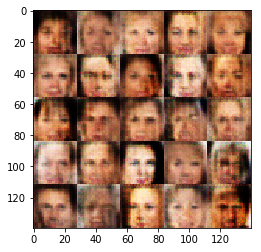

Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.7360
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 2.1928
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.3947
Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 1.4360
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.3799
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 0.9140


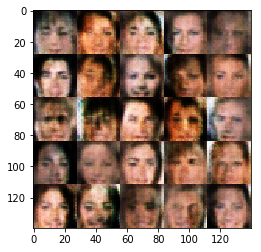

Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 1.7273
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 1.6222
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 1.4972
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.6534
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.3136
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.3760
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 1.8555
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.6735


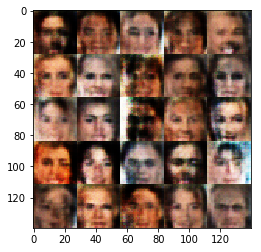

Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.6378
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 1.6194
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.3615
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.7426


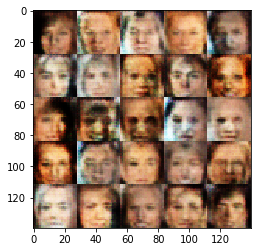

Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.5088
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.8617


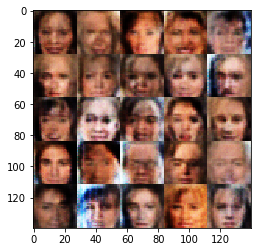

Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 1.8202
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 1.2010
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.4770
Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.3412
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.5154
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.6782


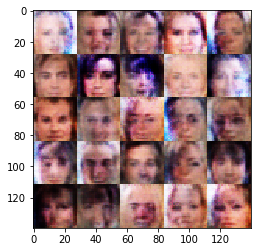

Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.2463
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.3790
Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 1.6896
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.6424
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.0178


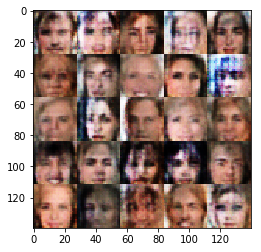

Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.6303
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 1.5443
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 1.1968
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 1.8563
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 1.7264
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.0439


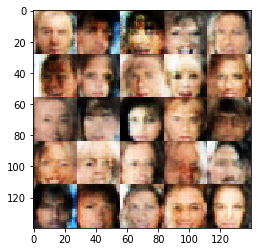

Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 0.6603... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 1.5999
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.2727
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 1.7290
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.2851
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.3309


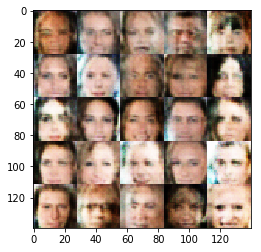

Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.5026
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.3561
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 1.2805


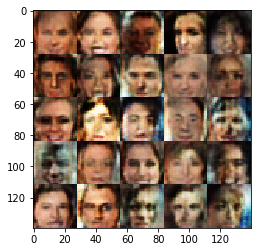

Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.8289
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 1.9083
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 2.0793
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 1.0370


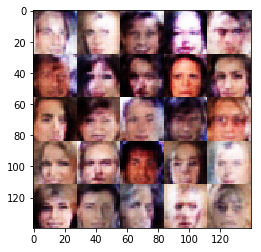

Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 1.5954
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.2532
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.4978
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 2.2566
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.4695
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 1.3843


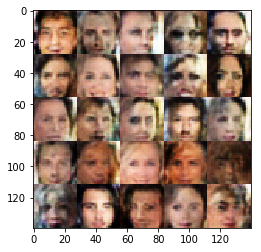

Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 3.3492
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 2.1050
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.7359


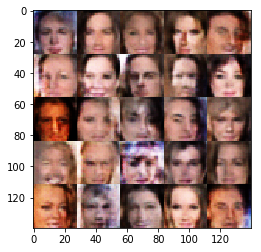

Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 1.7868
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 2.6478
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.4289
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.9201
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 1.8468
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.6026


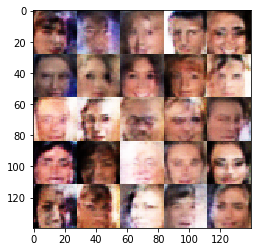

Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.3674
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 0.2787... Generator Loss: 1.9900
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.5285
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.7128


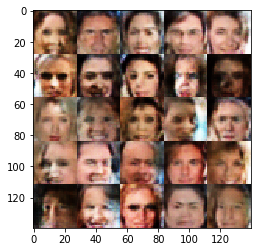

Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 0.4417... Generator Loss: 2.0692
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 2.5238
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.6867
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.1837
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 1.5838
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.6709
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.7446


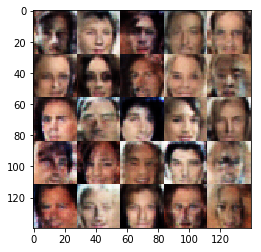

Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 1.5010
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.9888
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.4709
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 1.3348
Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 2.5982


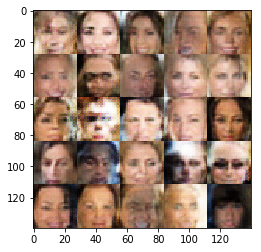

Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 2.3574
Epoch 1/1... Discriminator Loss: 1.7114... Generator Loss: 0.3003
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.4142
Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.5719
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 1.5351
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 2.6153


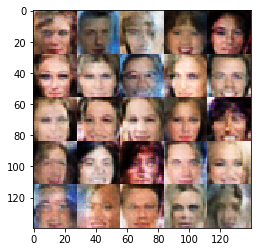

Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 2.0641
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 1.2888
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 1.8569
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.3516
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 1.5153
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 1.5931
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 1.7717


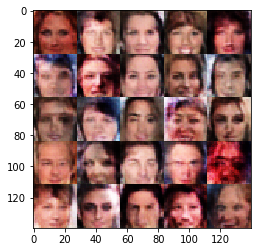

Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 0.6787... Generator Loss: 1.1933
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 2.0546
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 2.0927
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 1.5983
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.1931


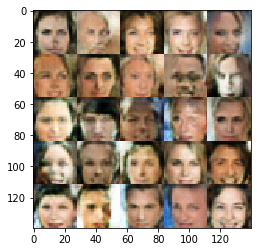

Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 1.4856
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 4.4094
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 2.0167
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 0.7505... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 4.7526
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.3088


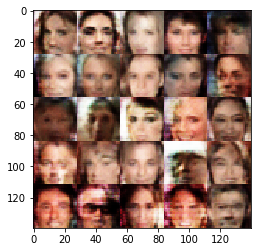

Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 1.8278
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 2.0466
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 0.7323


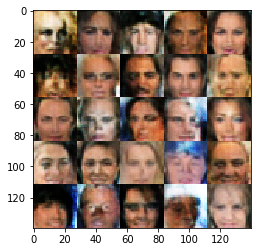

Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 1.6943
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 2.0130
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.7375
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.1057


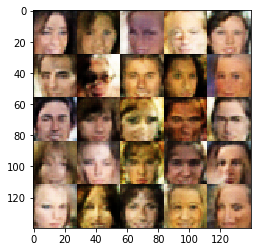

Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 1.7247
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 1.6270
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 1.8817
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 0.4723... Generator Loss: 1.7423
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 3.1518
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 1.9202


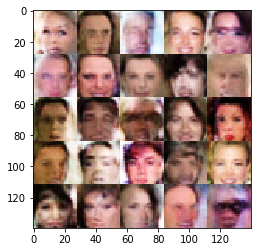

Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.4046
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.5300
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 2.1227
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.7199


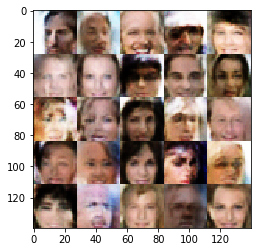

Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 1.8376
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.4733


NameError: name 'losses' is not defined

In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.